# Julia is fast

Very often, benchmarks are used to compare languages.  These benchmarks can lead to long discussions, first as to exactly what is being benchmarked and secondly what explains the differences.  These simple questions can sometimes get more complicated than you at first might imagine.

The purpose of this notebook is for you to see a simple benchmark for yourself.  One can read the notebook and see what happened on the author's Macbook Pro with a 4-core Intel Core I7, or run the notebook yourself.

(This material began life as a wonderful lecture by Steven Johnson at MIT: https://github.com/stevengj/18S096/blob/master/lectures/lecture1/Boxes-and-registers.ipynb.)

# Outline of this notebook

- Define the sum function
- Implementations & benchmarking of sum in...
    - C (hand-written)
    - C (hand-written with -ffast-math)
    - python (built-in)
    - python (numpy)
    - python (hand-written)
    - Julia (built-in)
    - Julia (hand-written)
    - Julia (hand-written with SIMD)
- Summary of benchmarks

# `sum`: An easy enough function to understand

Consider the  **sum** function `sum(a)`, which computes
$$
\mathrm{sum}(a) = \sum_{i=1}^n a_i,
$$
where $n$ is the length of `a`.

In [1]:
a = rand(10^7) # 1D vector of random numbers, uniform on [0,1)

10000000-element Vector{Float64}:
 0.975294601701897
 0.8624066446287034
 0.8422160866016808
 0.33344103053138185
 0.6943380852061868
 0.0666756654341466
 0.29672925186003374
 0.233983183823812
 0.4148380485170401
 0.20584151353663593
 0.5862437740408536
 0.8312459671362049
 0.5983727971425438
 ⋮
 0.6352490105732269
 0.17247458837865004
 0.9693138545843843
 0.400229508646855
 0.07380412837930106
 0.0722587843918614
 0.3888228089218506
 0.5675924819586521
 0.4459718816371855
 0.6743856449506023
 0.2536386807773964
 0.9040739231337452

In [2]:
sum(a)

5.000626451388976e6

The expected result is 0.5 * 10^7, since the mean of each entry is 0.5

# Benchmarking a few ways in a few languages

In [3]:
@time sum(a)

  0.007449 seconds (1 allocation: 16 bytes)


5.000626451388976e6

In [4]:
@time sum(a)

  0.007625 seconds (1 allocation: 16 bytes)


5.000626451388976e6

In [5]:
@time sum(a)

  0.007726 seconds (1 allocation: 16 bytes)


5.000626451388976e6

The `@time` macro can yield noisy results, so it's not our best choice for benchmarking!

Luckily, Julia has a `BenchmarkTools.jl` package to make benchmarking easy and accurate:

In [6]:
using Pkg
Pkg.add("BenchmarkTools")

   Resolving package versions...
  No Changes to `~/Src/Introduction-to-Julia/Project.toml`
  No Changes to `~/Src/Introduction-to-Julia/Manifest.toml`


In [7]:
using BenchmarkTools  

#  1. The C language

C is often considered the gold standard: difficult on the human, nice for the machine. Getting within a factor of 2 of C is often satisfying. Nonetheless, even within C, there are many kinds of optimizations possible that a naive C writer may or may not get the advantage of.

The current author does not speak C, so he does not read the cell below, but is happy to know that you can put C code in a Julia session, compile it, and run it. Note that the `"""` wrap a multi-line string.

In [8]:
using Libdl
C_code = """
#include <stddef.h>
double c_sum(size_t n, double *X) {
    double s = 0.0;
    for (size_t i = 0; i < n; ++i) {
        s += X[i];
    }
    return s;
}
"""

const Clib = tempname()   # make a temporary file


# compile to a shared library by piping C_code to gcc
# (works only if you have gcc installed):

open(`gcc -fPIC -O3 -msse3 -xc -shared -o $(Clib * "." * Libdl.dlext) -`, "w") do f
    print(f, C_code) 
end

# define a Julia function that calls the C function:
c_sum(X::Array{Float64}) = ccall(("c_sum", Clib), Float64, (Csize_t, Ptr{Float64}), length(X), X)

c_sum (generic function with 1 method)

In [9]:
c_sum(a)

5.000626451388183e6

In [10]:
c_sum(a) ≈ sum(a) # type \approx and then <TAB> to get the ≈ symbolb

true

In [11]:
c_sum(a) - sum(a)  

-7.925555109977722e-7

In [12]:
≈  # alias for the `isapprox` function

isapprox (generic function with 13 methods)

In [13]:
?isapprox

search: isapprox



```
isapprox(x, y; atol::Real=0, rtol::Real=atol>0 ? 0 : √eps, nans::Bool=false[, norm::Function])
```

Inexact equality comparison. Two numbers compare equal if their relative distance *or* their absolute distance is within tolerance bounds: `isapprox` returns `true` if `norm(x-y) <= max(atol, rtol*max(norm(x), norm(y)))`. The default `atol` (absolute tolerance) is zero and the default `rtol` (relative tolerance) depends on the types of `x` and `y`. The keyword argument `nans` determines whether or not NaN values are considered equal (defaults to false).

For real or complex floating-point values, if an `atol > 0` is not specified, `rtol` defaults to the square root of [`eps`](@ref) of the type of `x` or `y`, whichever is bigger (least precise). This corresponds to requiring equality of about half of the significant digits. Otherwise, e.g. for integer arguments or if an `atol > 0` is supplied, `rtol` defaults to zero.

The `norm` keyword defaults to `abs` for numeric `(x,y)` and to `LinearAlgebra.norm` for arrays (where an alternative `norm` choice is sometimes useful). When `x` and `y` are arrays, if `norm(x-y)` is not finite (i.e. `±Inf` or `NaN`), the comparison falls back to checking whether all elements of `x` and `y` are approximately equal component-wise.

The binary operator `≈` is equivalent to `isapprox` with the default arguments, and `x ≉ y` is equivalent to `!isapprox(x,y)`.

Note that `x ≈ 0` (i.e., comparing to zero with the default tolerances) is equivalent to `x == 0` since the default `atol` is `0`.  In such cases, you should either supply an appropriate `atol` (or use `norm(x) ≤ atol`) or rearrange your code (e.g. use `x ≈ y` rather than `x - y ≈ 0`).   It is not possible to pick a nonzero `atol` automatically because it depends on the overall scaling (the "units") of your problem: for example, in `x - y ≈ 0`, `atol=1e-9` is an absurdly small tolerance if `x` is the [radius of the Earth](https://en.wikipedia.org/wiki/Earth_radius) in meters, but an absurdly large tolerance if `x` is the [radius of a Hydrogen atom](https://en.wikipedia.org/wiki/Bohr_radius) in meters.

!!! compat "Julia 1.6"
    Passing the `norm` keyword argument when comparing numeric (non-array) arguments requires Julia 1.6 or later.


# Examples

```jldoctest
julia> isapprox(0.1, 0.15; atol=0.05)
true

julia> isapprox(0.1, 0.15; rtol=0.34)
true

julia> isapprox(0.1, 0.15; rtol=0.33)
false

julia> 0.1 + 1e-10 ≈ 0.1
true

julia> 1e-10 ≈ 0
false

julia> isapprox(1e-10, 0, atol=1e-8)
true

julia> isapprox([10.0^9, 1.0], [10.0^9, 2.0]) # using `norm`
true
```

---

```
isapprox(x; kwargs...) / ≈(x; kwargs...)
```

Create a function that compares its argument to `x` using `≈`, i.e. a function equivalent to `y -> y ≈ x`.

The keyword arguments supported here are the same as those in the 2-argument `isapprox`.

!!! compat "Julia 1.5"
    This method requires Julia 1.5 or later.



We can now benchmark the C code directly from Julia:

In [14]:
c_bench = @benchmark c_sum($a)

BenchmarkTools.Trial: 480 samples with 1 evaluation.
 Range (min … max):   9.889 ms …  16.728 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     10.183 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   10.389 ms ± 613.009 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

   ▅▅█▃▁▂                                                       
  ▆██████▇█▅▅▃▆▄▄▄▄▃▄▄▃▂▃▄▃▃▂▂▃▂▃▂▂▃▂▂▂▂▃▁▃▂▁▁▁▂▁▂▁▁▂▂▁▁▁▁▁▁▁▂ ▃
  9.89 ms         Histogram: frequency by time         12.7 ms <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [15]:
println("C: Fastest time was $(minimum(c_bench.times) / 1e6) msec")

C: Fastest time was 9.889295 msec


In [16]:
d = Dict()  # a "dictionary", i.e. an associative array
d["C"] = minimum(c_bench.times) / 1e6  # in milliseconds
d

Dict{Any, Any} with 1 entry:
  "C" => 9.8893

In [17]:
using Plots
gr()

Plots.GRBackend()

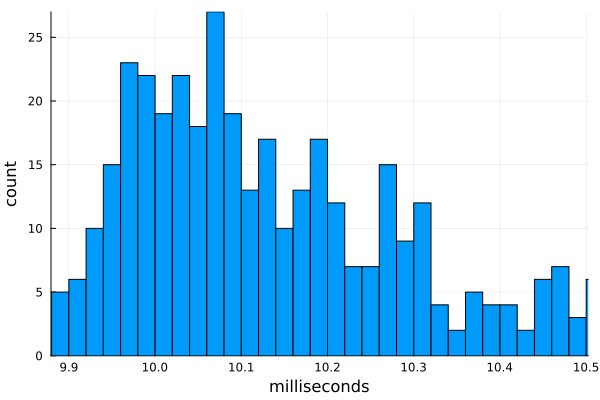

In [18]:
using Statistics # bring in statistical support for standard deviations
t = c_bench.times / 1e6 # times in milliseconds
m, σ = minimum(t), std(t)

histogram(t, bins=500,
    xlim=(m - 0.01, m + σ),
    xlabel="milliseconds", ylabel="count", label="")

# 2. C with -ffast-math

If we allow C to re-arrange the floating point operations, then it'll vectorize with SIMD (single instruction, multiple data) instructions.

In [19]:
const Clib_fastmath = tempname()   # make a temporary file

# The same as above but with a -ffast-math flag added
open(`gcc -fPIC -O3 -msse3 -xc -shared -ffast-math -o $(Clib_fastmath * "." * Libdl.dlext) -`, "w") do f
    print(f, C_code) 
end

# define a Julia function that calls the C function:
c_sum_fastmath(X::Array{Float64}) = ccall(("c_sum", Clib_fastmath), Float64, (Csize_t, Ptr{Float64}), length(X), X)

c_sum_fastmath (generic function with 1 method)

In [20]:
c_fastmath_bench = @benchmark $c_sum_fastmath($a)

BenchmarkTools.Trial: 890 samples with 1 evaluation.
 Range (min … max):  4.166 ms … 12.289 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     5.150 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   5.606 ms ±  1.280 ms  ┊ GC (mean ± σ):  0.00% ± 0.00%

   ▅█▆▁▂▄▃▅▂▃                                                 
  ▅██████████▇▆▆▆▆▆▅▇▅▆▅▅▄▅▄▅▄▄▄▄▅▅▄▄▃▄▃▃▂▂▄▃▂▃▃▃▂▃▃▃▂▂▂▁▂▂▂ ▄
  4.17 ms        Histogram: frequency by time        9.65 ms <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [21]:
d["C -ffast-math"] = minimum(c_fastmath_bench.times) / 1e6  # in milliseconds

4.166443

# 3. Python's built in `sum` 

The `PyCall` package provides a Julia interface to Python:

In [22]:
using Pkg; Pkg.add("PyCall")
using PyCall

   Resolving package versions...
  No Changes to `~/Src/Introduction-to-Julia/Project.toml`
  No Changes to `~/Src/Introduction-to-Julia/Manifest.toml`


In [23]:
# get the Python built-in "sum" function:
pysum = pybuiltin("sum")

PyObject <built-in function sum>

In [24]:
pysum(a)

5.000626451388183e6

In [25]:
pysum(a) ≈ sum(a)

true

In [26]:
py_list_bench = @benchmark $pysum($a)

BenchmarkTools.Trial: 9 samples with 1 evaluation.
 Range (min … max):  576.654 ms … 588.622 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     578.734 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   579.515 ms ±   3.821 ms  ┊ GC (mean ± σ):  0.00% ± 0.00%

  █▁    ▁   ▁█                ▁                               ▁  
  ██▁▁▁▁█▁▁▁██▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█ ▁
  577 ms           Histogram: frequency by time          589 ms <

 Memory estimate: 240 bytes, allocs estimate: 6.

In [27]:
d["Python built-in"] = minimum(py_list_bench.times) / 1e6
d

Dict{Any, Any} with 3 entries:
  "C"               => 9.8893
  "Python built-in" => 576.654
  "C -ffast-math"   => 4.16644

# 4. Python: `numpy` 

## Takes advantage of hardware "SIMD", but only works when it works.

`numpy` is an optimized C library, callable from Python.
It may be installed within Julia as follows:

In [29]:
#using Pkg; Pkg.add("Conda")
#using Conda

   Resolving package versions...
    Updating `~/Desktop/Introduction-to-Julia/Project.toml`
  [8f4d0f93] + Conda v1.5.2
  No Changes to `~/Desktop/Introduction-to-Julia/Manifest.toml`


In [30]:
#Conda.add("numpy")

┌ Info: Running `conda install -y numpy` in root environment
└ @ Conda /Users/logankilpatrick/.julia/packages/Conda/sNGum/src/Conda.jl:128


Solving environment: ...working... done

## Package Plan ##

  environment location: /Users/logankilpatrick/.julia/conda/3

  added / updated specs:
    - numpy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2021.7.5   |       hecd8cb5_1         113 KB
    conda-4.10.3               |   py38hecd8cb5_0         2.9 MB
    ------------------------------------------------------------
                                           Total:         3.0 MB

The following packages will be UPDATED:

  ca-certificates                      2021.5.25-hecd8cb5_1 --> 2021.7.5-hecd8cb5_1
  conda                               4.10.1-py38hecd8cb5_1 --> 4.10.3-py38hecd8cb5_0



ca-certificates-2021 | 113 KB    | #################################### | 100% 
conda-4.10.3         | 2.9 MB    | #################################### | 100% 
Preparing transaction: ...working... done
Verifying transa

In [28]:
numpy_sum = pyimport("numpy")["sum"]

py_numpy_bench = @benchmark $numpy_sum($a)

BenchmarkTools.Trial: 822 samples with 1 evaluation.
 Range (min … max):  4.240 ms … 16.390 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     5.493 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   6.072 ms ±  1.647 ms  ┊ GC (mean ± σ):  0.00% ± 0.00%

    ▁█▃▁                                                      
  ▄▅████▇▅▆▄▄▄▄▅▆▅▅▅▄▄▃▄▄▄▄▃▄▄▃▃▃▄▃▃▃▃▃▃▂▃▃▂▂▁▂▂▁▂▂▁▁▁▂▁▂▁▁▂ ▃
  4.24 ms        Histogram: frequency by time        11.9 ms <

 Memory estimate: 240 bytes, allocs estimate: 6.

In [29]:
numpy_sum(a)

5.000626451388977e6

In [30]:
numpy_sum(a) ≈ sum(a)

true

In [31]:
d["Python numpy"] = minimum(py_numpy_bench.times) / 1e6
d

Dict{Any, Any} with 4 entries:
  "C"               => 9.8893
  "Python numpy"    => 4.24007
  "Python built-in" => 576.654
  "C -ffast-math"   => 4.16644

# 5. Python, hand-written 

In [32]:
py"""
def py_sum(A):
    s = 0.0
    for a in A:
        s += a
    return s
"""

sum_py = py"py_sum"

PyObject <function py_sum at 0x177514550>

In [33]:
py_hand = @benchmark $sum_py($a)

BenchmarkTools.Trial: 7 samples with 1 evaluation.
 Range (min … max):  710.514 ms … 725.231 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     719.247 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   719.323 ms ±   5.358 ms  ┊ GC (mean ± σ):  0.00% ± 0.00%

  █                 █          █      █                 ██    █  
  █▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁██▁▁▁▁█ ▁
  711 ms           Histogram: frequency by time          725 ms <

 Memory estimate: 240 bytes, allocs estimate: 6.

In [34]:
sum_py(a)

5.000626451388183e6

In [35]:
sum_py(a) ≈ sum(a)

true

In [36]:
d["Python hand-written"] = minimum(py_hand.times) / 1e6
d

Dict{Any, Any} with 5 entries:
  "C"                   => 9.8893
  "Python numpy"        => 4.24007
  "Python hand-written" => 710.514
  "Python built-in"     => 576.654
  "C -ffast-math"       => 4.16644

# 6. Julia (built-in) 

## Written directly in Julia, not in C!

In [37]:
@which sum(a)

sum(a::AbstractArray; dims, kw...)
     @ Base reducedim.jl:1010

In [38]:
j_bench = @benchmark sum($a)

BenchmarkTools.Trial: 1033 samples with 1 evaluation.
 Range (min … max):  3.839 ms … 11.828 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     4.491 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   4.828 ms ±  1.006 ms  ┊ GC (mean ± σ):  0.00% ± 0.00%

    ▂▆█▇▁▁                                                    
  ▃▃████████▆▅▅▄▄▃▃▃▃▃▃▃▂▃▂▂▃▃▂▂▂▂▂▃▂▂▂▂▁▂▂▂▂▂▂▂▂▂▂▁▁▂▁▂▂▂▁▂ ▃
  3.84 ms        Histogram: frequency by time        9.56 ms <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [39]:
d["Julia built-in"] = minimum(j_bench.times) / 1e6
d

Dict{Any, Any} with 6 entries:
  "C"                   => 9.8893
  "Python numpy"        => 4.24007
  "Python hand-written" => 710.514
  "Python built-in"     => 576.654
  "Julia built-in"      => 3.83872
  "C -ffast-math"       => 4.16644

# 7. Julia (hand-written) 

In [40]:
function mysum(A)   
    s = 0.0 # s = zero(eltype(a))
    for a in A
        s += a
    end
    s
end

mysum (generic function with 1 method)

In [41]:
j_bench_hand = @benchmark mysum($a)

BenchmarkTools.Trial: 478 samples with 1 evaluation.
 Range (min … max):   9.803 ms …  13.399 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     10.221 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   10.449 ms ± 638.697 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

  ▂▅▃▇█▃▂▂▆   ▃                                                 
  ██████████▆▆█▄▇▄▄▆▆▃▄▄▅▄▄▃▄▃▃▄▃▃▄▃▃▃▂▁▂▃▄▃▂▁▂▁▂▁▂▁▂▁▁▃▂▂▁▁▁▃ ▃
  9.8 ms          Histogram: frequency by time         12.8 ms <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [42]:
d["Julia hand-written"] = minimum(j_bench_hand.times) / 1e6
d

Dict{Any, Any} with 7 entries:
  "C"                   => 9.8893
  "Python numpy"        => 4.24007
  "Julia hand-written"  => 9.8034
  "Python hand-written" => 710.514
  "Python built-in"     => 576.654
  "Julia built-in"      => 3.83872
  "C -ffast-math"       => 4.16644

# 8. Julia (hand-written w. simd) 

In [43]:
function mysum_simd(A)   
    s = 0.0 # s = zero(eltype(A))
    @simd for a in A
        s += a
    end
    s
end

mysum_simd (generic function with 1 method)

In [44]:
j_bench_hand_simd = @benchmark mysum_simd($a)

BenchmarkTools.Trial: 1044 samples with 1 evaluation.
 Range (min … max):  3.860 ms …   8.122 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     4.500 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   4.776 ms ± 763.014 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

   ▁▅▇▇█▆▆█▄▂▄ ▁                                               
  ▅███████████▇██▇▅▆▅▆▅▅▅▆▆▆▅▇▆▅▅▅▄▅▅▅▅▃▅▃▃▄▄▂▃▂▃▃▃▃▂▃▂▂▂▂▂▁▂ ▄
  3.86 ms         Histogram: frequency by time         7.2 ms <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [45]:
mysum_simd(a)

5.00062645138901e6

In [46]:
d["Julia hand-written simd"] = minimum(j_bench_hand_simd.times) / 1e6
d

Dict{Any, Any} with 8 entries:
  "Julia hand-written simd" => 3.86027
  "C"                       => 9.8893
  "Python numpy"            => 4.24007
  "Julia hand-written"      => 9.8034
  "Python hand-written"     => 710.514
  "Python built-in"         => 576.654
  "Julia built-in"          => 3.83872
  "C -ffast-math"           => 4.16644

# Summary

In [47]:
for (key, value) in sort(collect(d), by=last)
    println(rpad(key, 25, "."), lpad(round(value; digits=1), 6, "."))
end

Julia built-in..............3.8
Julia hand-written simd.....3.9
C -ffast-math...............4.2
Python numpy................4.2
Julia hand-written..........9.8
C...........................9.9
Python built-in...........576.7
Python hand-written.......710.5
